In [43]:
from pathlib import Path
import pandas as pd

file_path = Path(r'C:\Users\Murad\DSI_Assignments\C6_ML5\Data\Raw\Sample - Superstore.csv')


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform

# 1) Load & engineer features

df = pd.read_csv(file_path, encoding='latin1', parse_dates=['Order Date','Ship Date'])

df['Order_Month']    = df['Order Date'].dt.month
df['Month_sin']      = np.sin(2*np.pi*(df['Order_Month']-1)/12)
df['Month_cos']      = np.cos(2*np.pi*(df['Order_Month']-1)/12)
df['Order_Weekday']  = df['Order Date'].dt.weekday
df['Weekday_sin']    = np.sin(2*np.pi*df['Order_Weekday']/7)
df['Weekday_cos']    = np.cos(2*np.pi*df['Order_Weekday']/7)
df['Ship_Delay']     = (df['Ship Date'] - df['Order Date']).dt.days
df['Bulk_Flag']      = (df['Quantity'] > df['Quantity'].quantile(0.75)).astype(int)
df['Log_Quantity']   = np.log1p(df['Quantity'])
df['Quantity_Sq']    = df['Quantity']**2
df['Discount_to_Qty']= df['Discount']/(df['Quantity']+1e-6)
df['Profit_per_Unit']= df['Profit']/(df['Quantity']+1e-6)
df['Cat_Mean_Qty']   = df.groupby('Category')['Quantity'].transform('mean')
df['Cat_STD_Qty']    = df.groupby('Category')['Quantity'].transform('std').fillna(0)
df['Subcat_Mean_Discount']=df.groupby('Sub-Category')['Discount'].transform('mean')
df['Subcat_STD_Discount']=df.groupby('Sub-Category')['Discount'].transform('std').fillna(0)
df = df.sort_values(['Customer ID','Order Date'])
df['Prev_Order_Date']=df.groupby('Customer ID')['Order Date'].shift(1)
df['Days_Since_Last_Order']=(df['Order Date']-df['Prev_Order_Date']).dt.days.fillna(-1)
df['Cust_Order_Count']=df.groupby('Customer ID')['Order ID'].transform('nunique')
df['Cust_Mean_Qty']   =df.groupby('Customer ID')['Quantity'].transform('mean')
df['Items_per_Order'] =df.groupby('Order ID')['Quantity'].transform('sum')
df['Unique_Products'] =df.groupby('Order ID')['Sub-Category'].transform('nunique')

cats = ['Category','Sub-Category','Region','Segment','Ship Mode']
nums = ['Quantity','Discount','Profit']
eng  = [
    'Month_sin','Month_cos','Weekday_sin','Weekday_cos','Ship_Delay',
    'Bulk_Flag','Log_Quantity','Quantity_Sq','Discount_to_Qty','Profit_per_Unit',
    'Cat_Mean_Qty','Cat_STD_Qty','Subcat_Mean_Discount','Subcat_STD_Discount',
    'Days_Since_Last_Order','Cust_Order_Count','Cust_Mean_Qty',
    'Items_per_Order','Unique_Products'
]
features = cats + nums + eng
target   = 'Sales'

df = df.dropna(subset=features + [target])
X = df[features]
y = df[target]

# 2) Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) Preprocessor
preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), cats)
], remainder='passthrough')

# 4) Pipeline + RandomizedSearchCV
rf_pipe = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

param_dist = {
    'model__n_estimators': randint(100, 500),
    'model__max_depth': randint(5, 20),
    'model__min_samples_leaf': randint(5, 50),
    'model__max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7]
}

search = RandomizedSearchCV(
    rf_pipe, param_dist, n_iter=30, cv=5,
    scoring='r2', random_state=42, n_jobs=-1, verbose=1
)
search.fit(X_train, y_train)

best = search.best_estimator_
print("Best hyperparameters:", search.best_params_)

# 5) Evaluate best model 
train_pred = best.predict(X_train)
test_pred  = best.predict(X_test)

#  R²
r2_train = r2_score(y_train, train_pred)
r2_test  = r2_score(y_test,  test_pred)

# Adjusted R²
n_train, n_test = len(y_train), len(y_test)
p = len(features)
adj_r2_train = 1 - (1 - r2_train) * (n_train - 1) / (n_train - p - 1)
adj_r2_test  = 1 - (1 - r2_test)  * (n_test  - 1) / (n_test  - p - 1)

print("After tuning:")
print(f"  Train → RMSE: {root_mean_squared_error(y_train, train_pred):.2f}, "
      f"R²: {r2_train:.4f}, Adjusted R²: {adj_r2_train:.4f}")
print(f"  Test  → RMSE: {root_mean_squared_error(y_test,  test_pred):.2f}, "
      f"R²: {r2_test:.4f}, Adjusted R²: {adj_r2_test:.4f}")

mape_test = mean_absolute_percentage_error(y_test, test_pred) * 100  # percent
print(f"Test MAPE: {mape_test:.2f}%")

# And similarly for training:
mape_train = mean_absolute_percentage_error(y_train, train_pred) * 100
print(f"Train MAPE: {mape_train:.2f}%")

def smape(y_true, y_pred, epsilon=1e-8):
    """
    Symmetric Mean Absolute Percentage Error.
    """
    num = np.abs(y_pred - y_true)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(num / (den + epsilon)) * 100

# Compute SMAPE
smape_train = smape(y_train, train_pred)
smape_test  = smape(y_test,  test_pred)

print(f"Train SMAPE: {smape_train:.2f}%")
print(f"Test  SMAPE: {smape_test:.2f}%")

def smape(y_true, y_pred, epsilon=1e-8):
    """
    Symmetric Mean Absolute Percentage Error.
    """
    num = np.abs(y_pred - y_true)
    den = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(num / (den + epsilon)) * 100

# Compute SMAPE
smape_train = smape(y_train, train_pred)
smape_test  = smape(y_test,  test_pred)



Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'model__max_depth': 17, 'model__max_features': 0.7, 'model__min_samples_leaf': 5, 'model__n_estimators': 444}
After tuning:
  Train → RMSE: 280.41, R²: 0.8044, Adjusted R²: 0.8037
  Test  → RMSE: 269.58, R²: 0.7826, Adjusted R²: 0.7796
Test MAPE: 48.86%
Train MAPE: 35.88%
Train SMAPE: 25.34%
Test  SMAPE: 31.66%


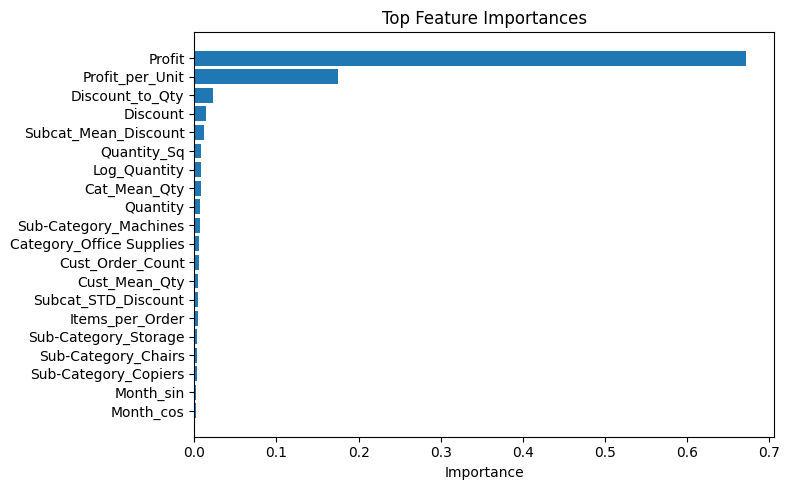

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Grab the best pipeline
best_pipe = search.best_estimator_

# 2) Determine feature names
if 'prep' in best_pipe.named_steps:
    feat_names = best_pipe.named_steps['prep'].get_feature_names_out()
    feat_names = [n.split("__",1)[1] for n in feat_names]
else:
    
    feat_names = [
        'Profit',
        'Profit_per_Unit',
        'Discount_to_Qty',
        'Discount',
        'Subcat_Mean_Discount'
    ]

# 3) importances
importances = best_pipe.named_steps['model'].feature_importances_

# 4) Build & sort DataFrame
imp_df = pd.DataFrame({
    'feature': feat_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(20)

# 5) Plot 
plt.figure(figsize=(8,5))
plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
plt.xlabel('Importance')
plt.title('Top Feature Importances')
plt.tight_layout()
plt.show()
